# Accelerating XGBoost with JAX

⚠️ If you are running this notebook in Colab, you will have to install `Ivy` and some dependencies manually. You can do so by running the cell below ⬇️

If you want to run the notebook locally but don't have Ivy installed just yet, you can check out the [Get Started section of the docs.](https://unify.ai/docs/ivy/overview/get_started.html)  

Make sure you run this demo with GPU enabled!

In [ ]:
!pip install -q ivy
!pip install -q xgboost ipytest pandas matplotlib scikit-learn torch cryptography

# Imports

In [ ]:
import ivy; ivy.set_backend("jax")
import jax; jax.config.update("jax_enable_x64", True)

import ivy.functional.frontends.xgboost as xgb_frontend
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from timeit import timeit
import xgboost as xgb
import pandas as pd
import functools
import ipytest; ipytest.autoconfig()
from tqdm import tqdm_notebook as tqdm

ivy.set_soft_device_mode(True)

# Tests
These tests are solely used to verify we're running with GPU.

In [4]:
%%ipytest
# functions to verify we're running with GPU
def test_jax_gpu():
    from jax.lib import xla_bridge
    assert xla_bridge.get_backend().platform == "gpu"

def test_torch_gpu():
    import torch
    assert torch.cuda.is_available() == True

def test_xgboost_gpu(capsys):
    from sklearn.datasets import load_diabetes
    dataset = load_diabetes()
    X = dataset["data"]
    y = dataset["target"]
    xgb_model = xgb.XGBRegressor(
        # If there is no GPU, the tree_method kwarg will cause either
        # - an error in `xgb_model.fit(X, y)` or
        # - a warning printed to the console.
        tree_method="gpu_hist"
    )
    xgb_model.fit(X, y)
    captured = capsys.readouterr()
    assert captured.out == ""
    assert captured.err == ""

...                                                                                          [100%]
3 passed in 4.99s


# Loading the Data
For comparing both implementations, we are using the [Binary Classification with a Tabular Pulsar Dataset](https://www.kaggle.com/competitions/playground-series-s3e10/data?select=train.csv). <br>
The following functions are employed to load the data, preprocess it (removing the _id_ and _Class_ columns, as well as standardizing the features), and converting both arrays into __ivy.Array__, while also adding an extra dimension to the labels.


In [16]:
def load_data(path):
    from sklearn.preprocessing import StandardScaler

    df = pd.read_csv(path, delimiter=",")
    y = df.Class.to_numpy()
    df.drop(columns=["id", "Class"], inplace=True)

    sc = StandardScaler()
    df = sc.fit_transform(df)
    return df, y

def prepare_data(arrays):
    if isinstance(arrays, tuple):
        arrays = list(arrays)

    for i in range(len(arrays)):
        if len(arrays[i].shape) == 1:
            arrays[i] = ivy.expand_dims(arrays[i], axis=1).astype(ivy.float32)
        else:
            arrays[i] = ivy.array(arrays[i], dtype=ivy.float32)
    return arrays

In [17]:
X, y = prepare_data(load_data("data/train.csv"))

In [18]:
# Checking the number of instances and features in data
print("Training data: ", X.shape)
print("Training target: ", y.shape)

Training data:  ivy.Shape(117564, 8)
Training target:  ivy.Shape(117564, 1)


# Comparing `xgb_frontend.XGBClassifier` and `xgb.XGBClassifier`
Let's compare the training times of both implementations using various backends. The structure of the demo allows you to navigate to the backend of your choice without having to rerun most of the previous cells.

`xgb_frontend.XGBClassifier` includes a `compile` method designed to optimize internal calculations, resulting in significant speed improvements.

## JAX  backend

In [ ]:
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "reg_lambda": 0.1,
    "reg_alpha": 0.1,
    "base_margin": None
}

xgb_cls = xgb.XGBClassifier(**params)

# ivy-based XGBClassifier should be compiled for better performance
ivy_cls = xgb_frontend.XGBClassifier(**params)
ivy_cls.compile(X, y)

In [21]:
%%timeit -n 10
xgb_cls.fit(X, y)

1.06 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit -n 10
ivy_cls.fit(X, y)

436 ms ± 48.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As you can see, when we **train** with the **JAX** backend and use compilation, it's much faster compared to the original way on T4 GPU on Colab! 🚀

It's important to consider that the speed-up factor is dependent on the GPU, so it would be better on higher-tier GPUs than T4 and reduced on lower-tier GPUs, although our experiments consistently demonstrate that it still results in a substantial performance boost.

Now, let's dive into predicting stuff and doing sanity check using the **classification_report** tool.

In [23]:
%timeit -n 100 xgb_cls.predict(X)

30 ms ± 9.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit -n 100 ivy_cls.predict(X)

1.56 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**~20x** faster **inference** on JAX backend!

In [24]:
ivy_pred = ivy_cls.predict(X)
xgb_pred = xgb_cls.predict(X)

print("IvyClassifier: \n", classification_report(y, ivy_pred))
print("\nXGBClassifier: \n", classification_report(y, xgb_pred))

IvyClassifier: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    106597
         1.0       0.99      0.33      0.50     10967

    accuracy                           0.94    117564
   macro avg       0.96      0.67      0.73    117564
weighted avg       0.94      0.94      0.92    117564


XGBClassifier: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    106597
         1.0       0.99      0.33      0.50     10967

    accuracy                           0.94    117564
   macro avg       0.96      0.67      0.73    117564
weighted avg       0.94      0.94      0.92    117564



## Tensorflow backend

In [ ]:
ivy.set_backend("tensorflow")
X, y = prepare_data(load_data("data/train.csv"))

In [ ]:
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "reg_lambda": 0.1,
    "reg_alpha": 0.1,
    "base_margin": None
}

xgb_cls = xgb.XGBClassifier(**params)

ivy_cls = xgb_frontend.XGBClassifier(**params)
ivy_cls.compile(X, y)

In [28]:
%%timeit -n 10
xgb_cls.fit(X, y)

1.06 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%timeit -n 10
ivy_cls.fit(X, y)

852 ms ± 449 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%timeit -n 100 xgb_cls.predict(X)

24.1 ms ± 7.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit -n 100 ivy_cls.predict(X)

2.82 ms ± 68.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Training with the Tensorflow backend and enabling compilation does improve speed compared to the original implementation. Nevertheless, it falls short of the blazing ~20x speed-up achieved with the JAX backend.

## PyTorch backend

In [31]:
ivy.set_backend("torch")
X, y = prepare_data(load_data("data/train.csv"))

In [32]:
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "reg_lambda": 0.1,
    "reg_alpha": 0.1,
    "base_margin": None
}

xgb_cls = xgb.XGBClassifier(**params)

ivy_cls = xgb_frontend.XGBClassifier(**params)
ivy_cls.compile(X, y)

In [34]:
%%timeit -n 10
xgb_cls.fit(X, y)

1.03 s ± 96.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%%timeit -n 10
ivy_cls.fit(X, y)

1.29 s ± 62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit -n 100 xgb_cls.predict(X)

27.5 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%timeit -n 100 ivy_cls.predict(X)

3.37 ms ± 83.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Running with the PyTorch backend surpasses the original version on inference, but, it still falls short of the remarkable results achieved with the JAX backend.

## More exhaustive example
Let's artificially increase the size of our dataset, simply stacking it, and run training with JAX backend and compilation.

In [37]:
ivy.set_backend("jax")
X, y = prepare_data(load_data("data/train.csv"))

X_doubled = ivy.vstack([X, X])
y_doubled = ivy.vstack([y, y])

In [38]:
# explore the number of instances in the resulting dataset
print("Training data: ", X_doubled.shape)
print("Training target: ", y_doubled.shape)

Training data:  ivy.Shape(235128, 8)
Training target:  ivy.Shape(235128, 1)


In [39]:
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "reg_lambda": 0.1,
    "reg_alpha": 0.1,
    "base_margin": None
}

xgb_cls = xgb.XGBClassifier(**params)

ivy_cls = xgb_frontend.XGBClassifier(**params)
ivy_cls.compile(X_doubled, y_doubled)

In [41]:
%%timeit -n 10
xgb_cls.fit(X_doubled, y_doubled)

2.3 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit -n 10
ivy_cls.fit(X_doubled, y_doubled)

879 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit -n 100 xgb_cls.predict(X)

28.5 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit -n 100 ivy_cls.predict(X)

1.65 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Speed-up factor seems in line with previous observations.

# Evaluating Training Time vs. Number of Boosting Rounds
Let's examine the training time for the original XGBClassifier and Ivy implementation across a range of boosting round values from 100 to 600 and plot the results in a graph, with tests conducted using the JAX backend and compilation.

In [ ]:
num_boosting_rounds = [100, 200, 300, 400, 500, 600]
ivy_elapsed_time = {"training":[], "inference":[]}
xgb_elapsed_time = {"training":[], "inference":[]}

for n in tqdm(num_boosting_rounds):
    params["n_estimators"] = n

    ivy_cls = xgb_frontend.XGBClassifier(**params)
    ivy_cls.compile(X, y)

    xgb_cls = xgb.XGBClassifier(**params)

    ivy_time = timeit(functools.partial(ivy_cls.fit, X, y), number=5)
    ivy_elapsed_time["training"].append(ivy_time)

    xgb_time = timeit(functools.partial(xgb_cls.fit, X, y), number=5)
    xgb_elapsed_time["training"].append(xgb_time)

    ivy_time = timeit(functools.partial(ivy_cls.predict, X), number=5)
    ivy_elapsed_time["inference"].append(ivy_time)

    xgb_time = timeit(functools.partial(xgb_cls.predict, X), number=5)
    xgb_elapsed_time["inference"].append(xgb_time)

Text(0.5, 1.0, 'XGBClassifier training time comparison')

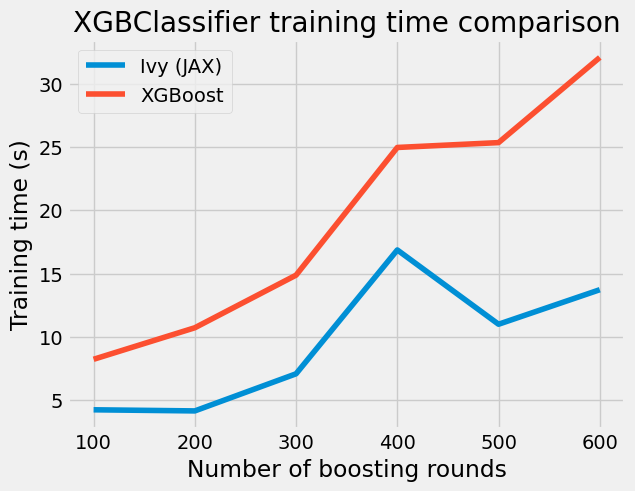

In [47]:
plt.style.use("fivethirtyeight")

plt.plot(num_boosting_rounds, ivy_elapsed_time["training"], label="Ivy (JAX)")
plt.plot(num_boosting_rounds, xgb_elapsed_time["training"], label="XGBoost")

plt.legend(loc="best")
plt.xlabel("Number of boosting rounds")
plt.ylabel("Training time (s)")
plt.title("XGBClassifier training time comparison")

Text(0.5, 1.0, 'XGBClassifier inference time comparison')

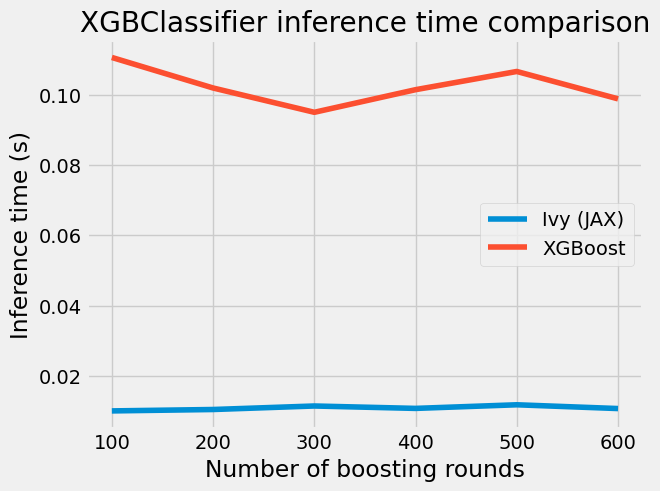

In [48]:
plt.style.use("fivethirtyeight")

plt.plot(num_boosting_rounds, ivy_elapsed_time["inference"], label="Ivy (JAX)")
plt.plot(num_boosting_rounds, xgb_elapsed_time["inference"], label="XGBoost")

plt.legend(loc="best")
plt.xlabel("Number of boosting rounds")
plt.ylabel("Inference time (s)")
plt.title("XGBClassifier inference time comparison")

We can observe an obvious trend: the longer we train - the more the gap in training time between both implementations.

# Training Time vs. Fractions of Data
Let's compare training times on various fractions of data within the range of [0.5, 0.9] and visualize the results in a graph. These tests will be performed using the JAX backend and compilation.


In [ ]:
sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
ivy_elapsed_time = {"training":[], "inference":[]}
xgb_elapsed_time = {"training":[], "inference":[]}

# let's slightly change the parameters this time
params = {
    "objective": "binary:logistic",
    "booster": "gblinear",
    "n_estimators": 300,
    "learning_rate": 0.15,
    "reg_lambda": 0.3,
    "reg_alpha": 0.05,
    "base_margin": None
}

for s in tqdm(sizes):
    X_train, _, y_train, _ = train_test_split(X, y, train_size=s, random_state=15)

    ivy_cls = xgb_frontend.XGBClassifier(**params)
    ivy_cls.compile(X_train, y_train)

    xgb_cls = xgb.XGBClassifier(**params)

    ivy_time = timeit(functools.partial(ivy_cls.fit, X_train, y_train), number=5)
    ivy_elapsed_time["training"].append(ivy_time)

    xgb_time = timeit(functools.partial(xgb_cls.fit, X_train, y_train), number=5)
    xgb_elapsed_time["training"].append(xgb_time)

    ivy_time = timeit(functools.partial(ivy_cls.predict, X_train), number=5)
    ivy_elapsed_time["inference"].append(ivy_time)

    xgb_time = timeit(functools.partial(xgb_cls.predict, X_train), number=5)
    xgb_elapsed_time["inference"].append(xgb_time)

Text(0.5, 1.0, 'XGBClassifier training time comparison')

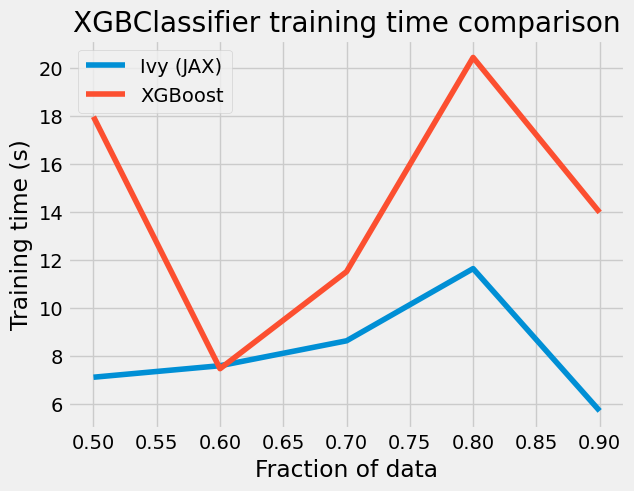

In [50]:
plt.style.use("fivethirtyeight")

plt.plot(sizes, ivy_elapsed_time["training"], label="Ivy (JAX)")
plt.plot(sizes, xgb_elapsed_time["training"], label="XGBoost")

plt.legend(loc="best")
plt.xlabel("Fraction of data")
plt.ylabel("Training time (s)")
plt.title("XGBClassifier training time comparison")

Text(0.5, 1.0, 'XGBClassifier inference time comparison')

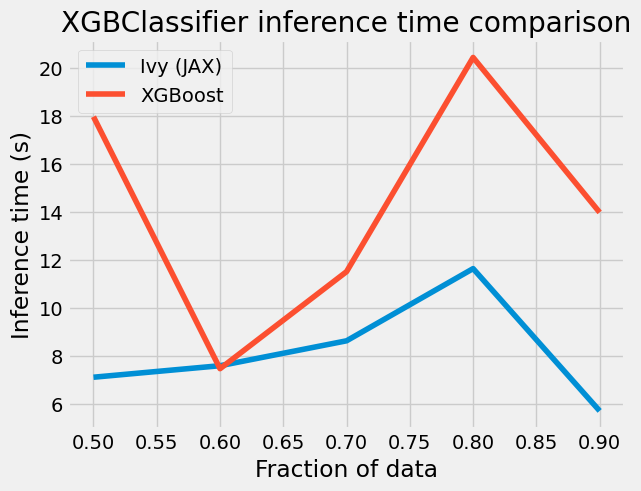

In [51]:
plt.style.use("fivethirtyeight")

plt.plot(sizes, ivy_elapsed_time["training"], label="Ivy (JAX)")
plt.plot(sizes, xgb_elapsed_time["training"], label="XGBoost")

plt.legend(loc="best")
plt.xlabel("Fraction of data")
plt.ylabel("Inference time (s)")
plt.title("XGBClassifier inference time comparison")

We can observe a clear trend here: as we increase the amount of data, the gap in training time between both implementations widens. This has resulted in an impressive outcome; however, it's important to note that for small datasets, the original XGBClassifier tends to outperform our implementation.

Now, as a sanity check, let's proceed to compare various metrics.

In [52]:
ivy_pred = ivy_cls.predict(X_train)
xgb_pred = xgb_cls.predict(X_train)

print("IvyClassifier: \n", classification_report(y_train, ivy_pred))
print("\nXGBClassifier: \n", classification_report(y_train, xgb_pred))

IvyClassifier: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     95933
         1.0       0.99      0.40      0.57      9874

    accuracy                           0.94    105807
   macro avg       0.97      0.70      0.77    105807
weighted avg       0.95      0.94      0.93    105807


XGBClassifier: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     95933
         1.0       0.99      0.40      0.57      9874

    accuracy                           0.94    105807
   macro avg       0.97      0.70      0.77    105807
weighted avg       0.95      0.94      0.93    105807



# Comparison of Metrics
To wrap up, we will load a more balanced **Breast Cancer Classification** dataset, train both classifiers, and then compare the resulting metrics.

In [53]:
X, y = prepare_data(load_breast_cancer(return_X_y=True))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

ivy_cls.compile(X_train, y_train)
ivy_cls.fit(X_train, y_train)

xgb_cls.fit(X_train, y_train)

ivy_pred = ivy_cls.predict(X_test)
xgb_pred = xgb_cls.predict(X_test)

print("IvyClassifier: \n", classification_report(y_test, ivy_pred))
print("\nXGBClassifier: \n", classification_report(y_test, xgb_pred))

IvyClassifier: 
               precision    recall  f1-score   support

         0.0       0.92      0.76      0.83        63
         1.0       0.87      0.96      0.92       108

    accuracy                           0.89       171
   macro avg       0.90      0.86      0.88       171
weighted avg       0.89      0.89      0.89       171


XGBClassifier: 
               precision    recall  f1-score   support

         0.0       0.92      0.76      0.83        63
         1.0       0.87      0.96      0.92       108

    accuracy                           0.89       171
   macro avg       0.90      0.86      0.88       171
weighted avg       0.89      0.89      0.89       171



As you can see, they perfectly align. And that's a wrap! The results from both models are identical, but we've gained a substantial speed boost by using different backends in combination with Ivy!